In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.full.HelperFunctions.LabelEncoder import LabelEncoder
from ipynb.fs.full.HelperFunctions.Pickle import save_to_pickle
from ipynb.fs.full.HelperFunctions.Preprocessing import ZscoreNormalisation, PCA, get_dataframe_with_columns, get_category_mode
from ipynb.fs.full.HelperFunctions.Preprocessing import get_dataframe_with_columns
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore")

In [2]:
def run(imputation,mean,pca_components):

    # Data obtained from the following kaggle dataset
    # https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
    source = 'Data/weatherAUS.csv'

    data = pd.read_csv(source, parse_dates=['Date'])

    # Dropping features which have a high numbers of NA's
    data = data.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1)

    # Dropping data samples where 'RainTomorrow' the dependent variable is unknown
    data = data.dropna(subset=['RainTomorrow'])

    categorical_variable_names = ['Year', 'Month','Day', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
    continuous_variable_names = ['MinTemp', 'MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Temp9am','Temp3pm']

    # Two choices two deal with the remaining NA's
    # 1. Drop all samples which have at least 1 NA
    # 2. Predict the NA value with mode

    if imputation:
        # Filling each na values of continuous variables with the mode.
        for continuous_variable_name in continuous_variable_names:
            data[continuous_variable_name] = data[continuous_variable_name].fillna(data[continuous_variable_name].mode()[0])

        # Filling each na values of categorical variables with the mode.
        for categorical_variable_name in categorical_variable_names:
            if categorical_variable_name in ['Year','Month','Day','Location']:
                continue
            mode_category = get_category_mode(data[categorical_variable_name])
            data[categorical_variable_name] = data[categorical_variable_name].fillna(mode_category)

    else:
        # Dropping all samples which have at least 1 NA
        data = data.dropna()

    # Splitting up the data into 3 features year, month, day
    # label encoding each of these new features
    # https://stackoverflow.com/questions/57767968/split-date-in-formatyyyy-mm-dd-into-3-new-columns-in-dataframe-as-year-month

    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day

    # Dropping the Date feature since it is not split up into different columns
    data = data.drop(['Date'], axis=1)


    # Label Encoding each categorical feature
    # Label encoding for date features are required since these are not labels (dont start from zero)
    year_LB = LabelEncoder()
    data = year_LB.transform(data, 'Year')

    month_LB = LabelEncoder()
    data = month_LB.transform(data, 'Month')

    day_LB = LabelEncoder()
    data = day_LB.transform(data, 'Day')

    location_LB = LabelEncoder()
    data = location_LB.transform(data, 'Location')

    windGustDir_LB = LabelEncoder()
    data = windGustDir_LB.transform(data, 'WindGustDir')

    windDir9am_LB = LabelEncoder()
    data = windDir9am_LB.transform(data, 'WindDir9am')

    windDir3pm_LB = LabelEncoder()
    data = windDir3pm_LB.transform(data, 'WindDir3pm')

    rainToday_LB = LabelEncoder()
    data = rainToday_LB.transform(data, 'RainToday')

    rainTomorrow_LB = LabelEncoder()
    data = rainTomorrow_LB.transform(data, 'RainTomorrow')

    # Generating the mutual information between categorical variables and the dependent variable
    mi = mutual_info_classif(get_dataframe_with_columns(data, ['Year', 'Month', 'Day', 'Location', 'WindGustDir', 'WindDir9am',
                                                  'WindDir3pm', 'RainToday']), data['RainTomorrow'].astype('int'),discrete_features=True)
    column_names = np.array(['Year', 'Month', 'Day', 'Location', 'WindGustDir', 'WindDir9am','WindDir3pm', 'RainToday'])

    # Sorting indices of mi from largest to smallest
    sorted_indices = np.argsort(mi)[::-1]
    sorted_column_names = column_names[sorted_indices]
    sorted_mi = mi[sorted_indices]

    # Plotting box plot of Mutual information
    fig = plt.figure(1)

    plt.figure(figsize=(24, 12))
    sns.barplot(y=sorted_column_names,x=sorted_mi, orient='h')
    plt.show()

    # Removing Month, Year and Day
    data = data.drop(['Month','Year','Day'], axis=1)
    categorical_variable_names.remove('Month')
    categorical_variable_names.remove('Year')
    categorical_variable_names.remove('Day')

    # Pearson Correlations
    plt.figure(figsize=(24, 12))
    sns.heatmap(data.corr(), annot=True)
    plt.show()

    # Generating the mean of the colums and removing from their respective array
    def add_mean_of_cols(data, mean_name, cols_to_mean):
        data[mean_name] = data[cols_to_mean].mean(axis=1)
        data = data.drop(cols_to_mean, axis=1)
        for col in cols_to_mean:
            continuous_variable_names.remove(col)
        continuous_variable_names.append(mean_name)
        return data

    if mean:
        # Getting mean for temperature
        data = add_mean_of_cols(data,'Mean_Temp',['MinTemp', 'MaxTemp'])
        data = data.drop(['Temp9am', 'Temp3pm'], axis=1)
        continuous_variable_names.remove('Temp9am')
        continuous_variable_names.remove('Temp3pm')

        # Getting mean for pressure
        data = add_mean_of_cols(data,'Mean_Pressure',['Pressure9am', 'Pressure3pm'])

    # Continuous Variables
    # ['MinTemp', 'MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Temp9am',Temp3pm]
    # Applying ZscoreNormalisation

    # Performing Z-Score Normalisation
    for col_name in (continuous_variable_names):
        if col_name == 'RainTomorrow':
            print(col_name)
            continue
        data = ZscoreNormalisation(data, col_name)

    data = data.reset_index(drop=True)
    categorical_variables_dataframe = get_dataframe_with_columns(data, categorical_variable_names)
    continuous_variables_dataframe = get_dataframe_with_columns(data, continuous_variable_names)

    # 6 was chosen as checking the eigen values
    data_pca = PCA(continuous_variables_dataframe,pca_components)

    # Combining both dataframe together
    data = pd.concat([data_pca, categorical_variables_dataframe],axis=1)

    # Separating data in X and y
    X = data.drop(['RainTomorrow'],axis=1).reset_index(drop=True)
    y = data.RainTomorrow.reset_index(drop=True).astype('int')

    x_filename = "Data"
    y_filename = "Data"

    if mean:
        x_filename += '/Mean'
        y_filename += '/Mean'
    else:
        x_filename += '/NoMean'
        y_filename += '/NoMean'

    if imputation:
        x_filename += '/X_with_imputation'
        y_filename += '/y_with_imputation'
    else:
        x_filename += '/X_without_imputation'
        y_filename += '/y_without_imputation'

    x_filename += '_PCA' + str(pca_components) + '.pickle'
    y_filename += '_PCA' + str(pca_components) + '.pickle'

    save_to_pickle(x_filename, X)
    save_to_pickle(y_filename, y)


PCA Component 5


<Figure size 432x288 with 0 Axes>

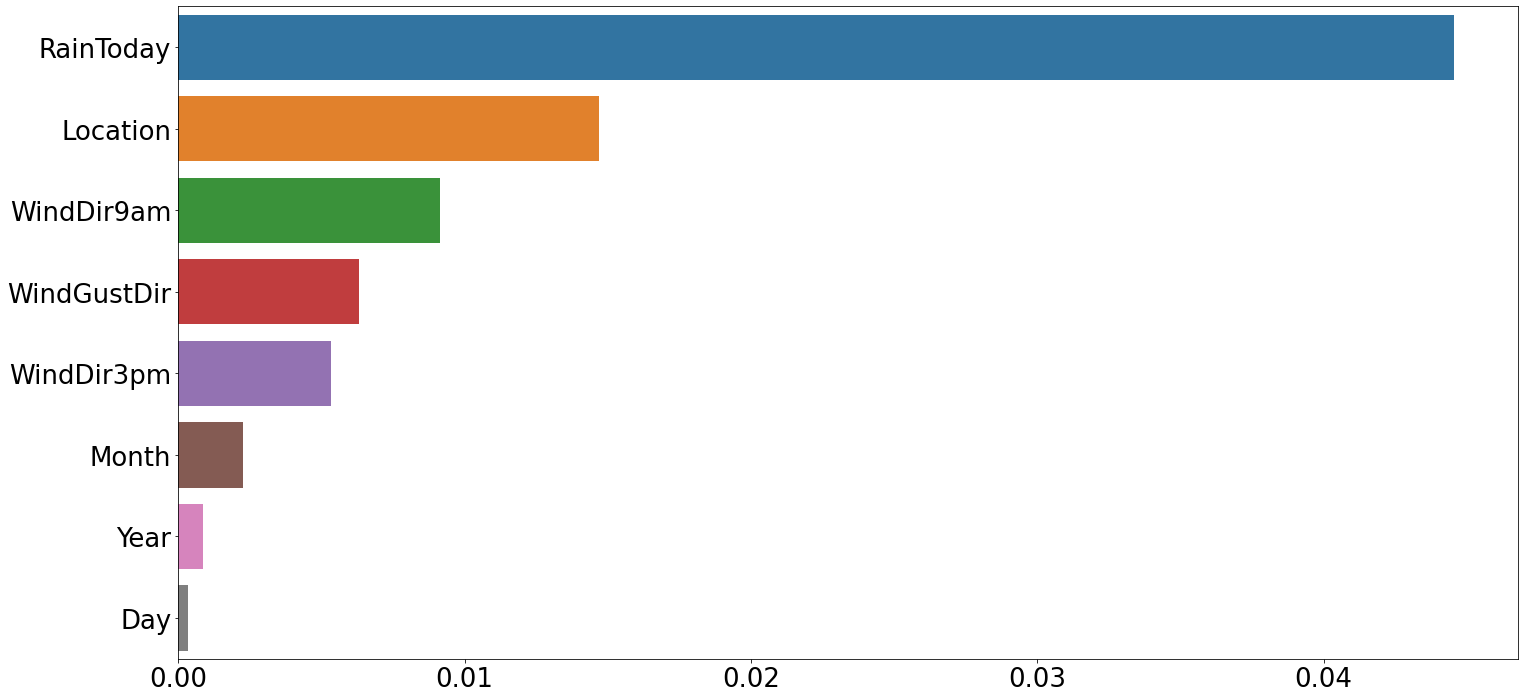

Eigen Values [4.61556247 2.54661953 1.70056919 1.03125741 0.80466695 0.51552739
 0.33701899 0.2673544  0.11025245 0.03386621 0.02660301 0.01080825]
Percentage of total variantion [38.46268002 21.22164148 14.17128445  8.59373565  6.70549852  4.29602356
  2.80846674  2.22793362  0.9187623   0.28221593  0.22168978  0.09006796]


<Figure size 432x288 with 0 Axes>

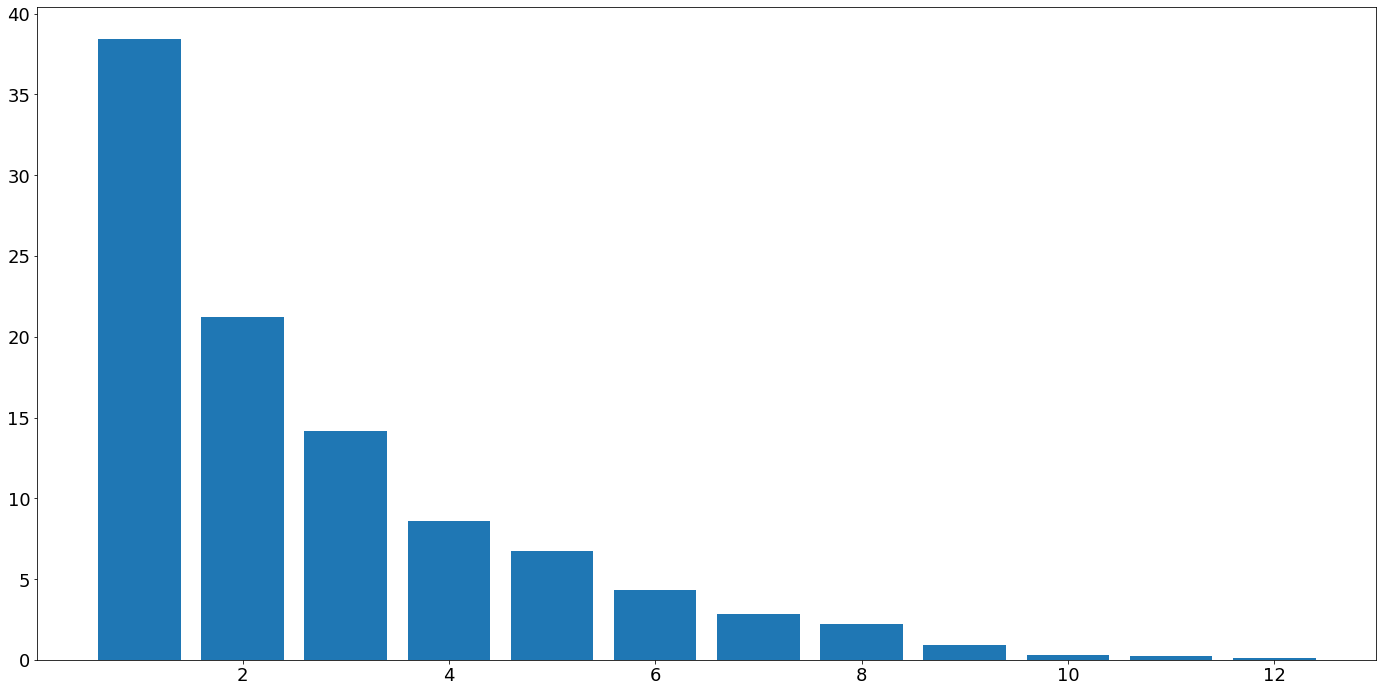


PCA Component 6


<Figure size 432x288 with 0 Axes>

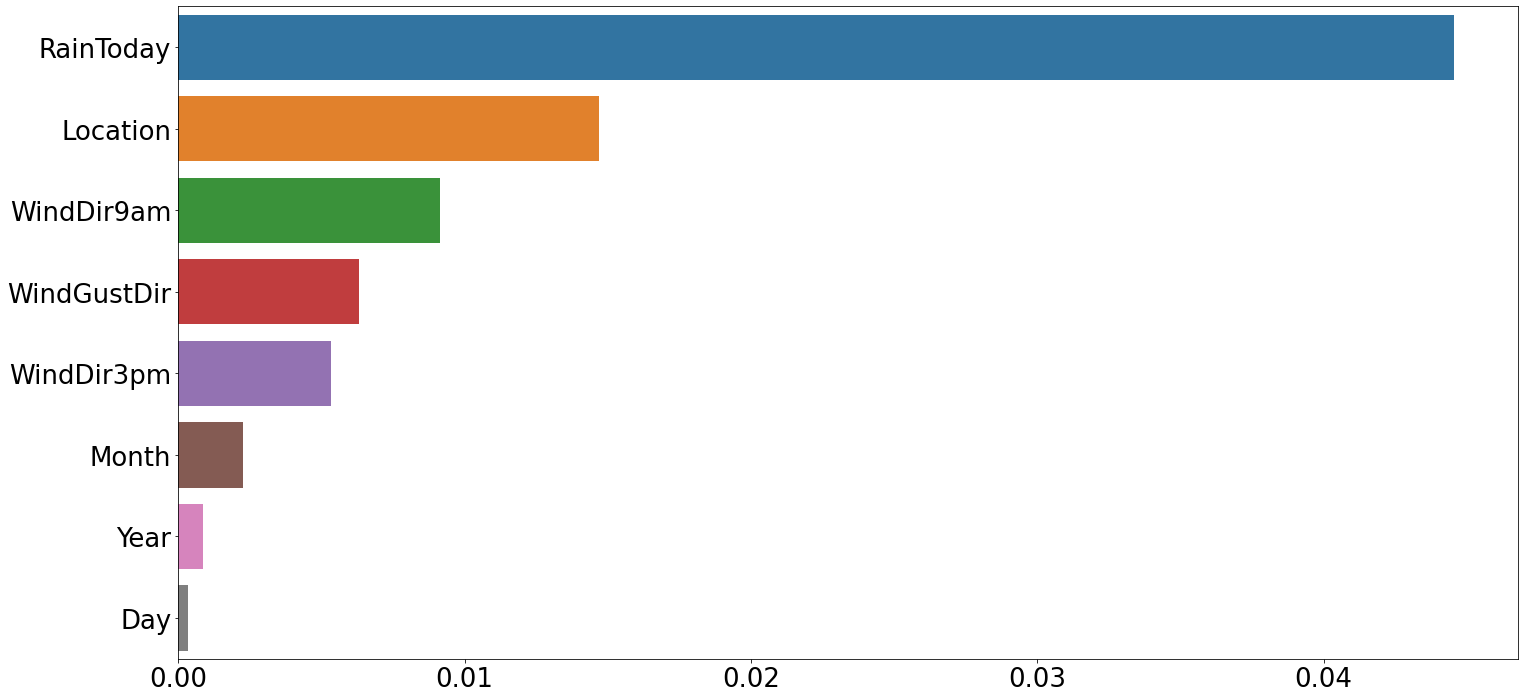

Eigen Values [4.61556247 2.54661953 1.70056919 1.03125741 0.80466695 0.51552739
 0.33701899 0.2673544  0.11025245 0.03386621 0.02660301 0.01080825]
Percentage of total variantion [38.46268002 21.22164148 14.17128445  8.59373565  6.70549852  4.29602356
  2.80846674  2.22793362  0.9187623   0.28221593  0.22168978  0.09006796]


<Figure size 432x288 with 0 Axes>

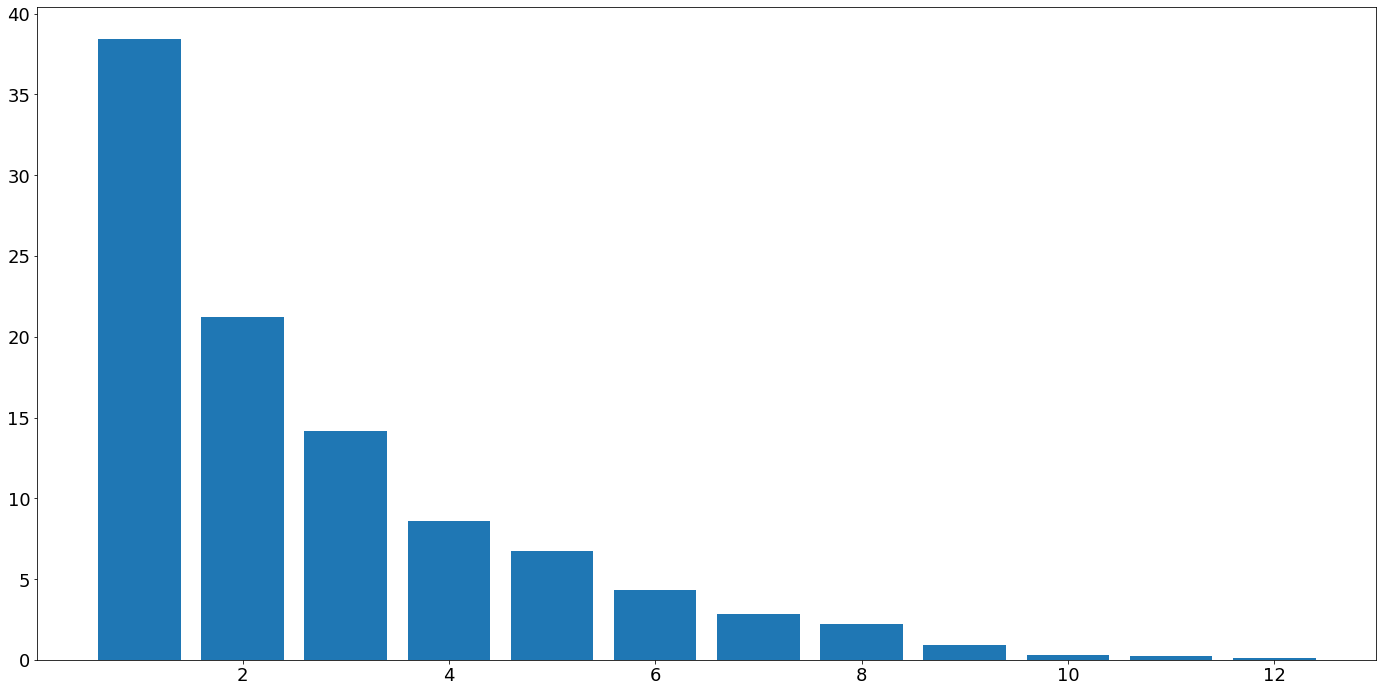

KeyboardInterrupt: 

In [3]:
if __name__ == '__main__':

    for i in range(5, 8, 1):
        print('PCA Component ' + str(i))
        run(imputation=False, mean=False, pca_components=i)
        print('')
